# Predict binding affinity from a protein-ligand crystal structure

In [1]:
# Packages installed in my conda environment: Deepchem, rdkit, pytorch, pytorch-geometric, tensorflow, pdbfixer, numpy <1.25
# jupyter notebook/ google colab
# Deep Learning for the Life Sciences by Bharath Ramsundar, Peter Eastman, Patrick Walters and Vijay Pande
# pdbbind dataset: Cheng, T.J. et al. J. Chem. Inf. Model., 2009, 49, 1079-1093. (PDBbind v.2009)

In [2]:
import deepchem as dc

C:\Users\pppdd\miniconda3\envs\tf\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.


In [3]:
featurizer = dc.feat.RdkitGridFeaturizer(voxel_width=2.0
                                        , feature_types=['ecfp', 'splif', 'salt_bridge', 'hbond']
                                        , flatten=True
                                        , sanitize=True)

In [4]:
tasks, datasets, transformers = dc.molnet.load_pdbbind(featurizer=featurizer, reload=False, set_name='core' )

C:\Users\pppdd\miniconda3\envs\tf\lib\site-packages\deepchem\utils\geometry_utils.py:22: RuntimeWarning: invalid value encountered in divide
  return vector / np.linalg.norm(vector)


In [5]:
tasks

['-logKd/Ki']

In [6]:
transformers

In [7]:
train, valid, test = datasets

In [9]:
print(train.X.dtype)
print(train.y.dtype)
print(train.w.dtype)

int8
float64
float32


In [10]:
x_train = train.X.astype('float32')
y_train = train.y.astype('float32')
w_train = train.w.astype('float32')

x_test = test.X.astype('float32')
y_test = test.y.astype('float32')
w_test = test.w.astype('float32')

In [11]:
x_train.dtype

dtype('float32')

In [13]:
train.X.shape

(154, 18432)

In [14]:
x_train.shape

(154, 18432)

In [15]:
train_dataset = dc.data.NumpyDataset(x_train, y_train, w_train)
test_dataset = dc.data.NumpyDataset(x_test, y_test, w_test)

In [18]:
train_dataset.X.shape

(154, 18432)

In [19]:
model = dc.models.MultitaskRegressor(n_tasks=1, n_features=train_dataset.X.shape[1], layer_sizes=[5000, 2000, 1000], dropouts=0.5)

In [20]:
model.fit(train_dataset, nb_epoch=200)

0.0620599889755249

In [21]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

In [22]:
train_score = model.evaluate(train_dataset, [metric], transformers)
print(train_score)

{'pearson_r2_score': 0.9961735077259087}


In [23]:
test_score = model.evaluate(test_dataset, [metric], transformers)
print(test_score)

{'pearson_r2_score': 0.22964646127693872}


In [25]:
test_dataset.X.shape

(20, 18432)

In [26]:
prediction = model.predict_on_batch(test_dataset.X)
prediction[:5]

array([[[ 0.49557406]],

       [[-0.11611837]],

       [[-0.5619836 ]],

       [[ 0.34860352]],

       [[ 0.60068214]]], dtype=float32)

In [27]:
test_dataset.y[:5]

array([-0.8548599 ,  0.2195263 , -0.08744118,  2.034246  ,  1.1314003 ],
      dtype=float32)

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
prediction.shape

(20, 1, 1)

In [32]:
prediction = prediction.reshape(20)
prediction.shape

(20,)

Text(0, 0.5, 'prediction')

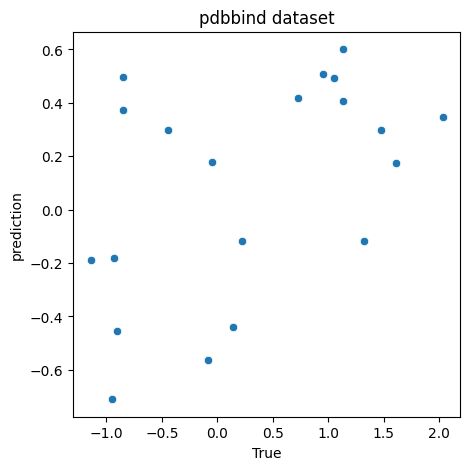

In [33]:
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.scatterplot(x=test_dataset.y, y=prediction)
ax.set_title('pdbbind dataset')
ax.set_xlabel('True')
ax.set_ylabel('prediction')